<a href="https://colab.research.google.com/github/OUCTheoryGroup/colab_demo/blob/master/HybridSN_GRSL2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HybridSN 高光谱分类

S. K. Roy, G. Krishna, S. R. Dubey, B. B. Chaudhuri
HybridSN: Exploring 3-D–2-D CNN Feature Hierarchy for Hyperspectral Image Classification, *IEEE GRSL* 2020

这篇论文构建了一个 混合网络 解决高光谱图像分类问题，首先用 3D卷积，然后使用 2D卷积，代码相对简单，下面是代码的解析。

首先取得数据，并引入基本函数库。

In [0]:
! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
! pip install spectral

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral

**定义基本变量及函数**

注意：因使用数据集的不同，X和y的文件名会有所变化。

In [0]:
# 地物类别
class_num = 16
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.9
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

In [0]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

## 1. 创建数据集

首先对高光谱数据实施PCA降维；然后创建 keras 方便处理的数据格式；然后随机抽取 10% 数据做为训练集，剩余的做为测试集。

In [0]:
print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 200)

... ... create data cubes ... ...
Data cube X shape:  (145, 145, 200)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)


## 2. 定义 HybridSN 类

模型的网络结构为如下图所示：

![HybridSN](http://q6dz4bbgt.bkt.clouddn.com/20200304203710.jpg)

三维卷积部分：
- conv1：（25, 25, 30, 1）， 8个 3x3x7 的卷积核 ==>（23, 23, 24, 8）
- conv2：（23, 23, 24, 8）， 16个 3x3x5 的卷积核 ==>（21, 21, 20, 16）
- conv3：（21, 21, 20, 16），32个 3x3x3 的卷积核 ==>（19, 19, 18, 32）

接下来要进行二维卷积，因此把最后的 18*32 reshape 一下，得到 （19, 19, 576）

二维卷积：（19, 19, 576），64个 3x3 的卷积核，得到 （17，17，64）

接下来是一个 flatten 操作，变为 18496 维的向量，

接下来依次为256，128节点的全连接层，都使用比例为0.4的 Dropout，

最后输出为 16 个节点，是最终的分类类别数。 

Keras 支持使用一个 summary 函数，输出整个网络结构，感兴趣可以关注一下，作者提供的原版代码里也有。

In [0]:
def HybridSN (input_data):
    ## convolutional layers
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_data)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
    print(conv_layer3._keras_shape)
    conv3d_shape = conv_layer3._keras_shape
    conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

    flatten_layer = Flatten()(conv_layer4)

    ## fully connected layers
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_data = Dense(units=class_num, activation='softmax')(dense_layer2)

    # define the model with input layer and output layer
    model = Model(inputs=input_data, outputs=output_data)

    return model

## 3. 开始训练

In [0]:
# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
ytrain = np_utils.to_categorical(ytrain)

print('... ... Xtrain & ytrain reshape ... ...')
print('Xtrain shape: ', Xtrain.shape) 
print('ytrain shape: ', ytrain.shape)

... ... Xtrain & ytrain reshape ... ...
Xtrain shape:  (1024, 25, 25, 30, 1)
ytrain shape:  (1024, 16)


In [0]:
# 初始化模型类
model = HybridSN( Input((patch_size, patch_size, pca_components, 1)) )
# 和 pytorch 类似，需要给模型定义 损失函数 和 优化器
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-06), \
              metrics=['accuracy'])

# checkpoint 把最好的结果保存下来
filepath = "./best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# 模型训练
model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

1024/1024 [==============================] - 16s 15ms/step - loss: 2.9183 - acc: 0.1250

Epoch 00001: acc improved from -inf to 0.12500, saving model to ./best-model.hdf5
Epoch 2/100
1024/1024 [==============================] - 1s 569us/step - loss: 2.7529 - acc: 0.1270

Epoch 00002: acc improved from 0.12500 to 0.12695, saving model to ./best-model.hdf5
Epoch 3/100
1024/1024 [==============================] - 1s 574us/step - loss: 2.6509 - acc: 0.1484

Epoch 00003: acc improved from 0.12695 to 0.14844, saving model to ./best-model.hdf5
Epoch 4/100
1024/1024 [==============================] - 1s 587us/step - loss: 2.4790 - acc: 0.1934

Epoch 00004: acc improved from 0.14844 to 0.19336, saving model to ./best-model.hdf5
Epoch 5/100
1024/1024 [==============================] - 1s 580us/step - loss: 2.4697 - acc: 0.1973

Epoch 00005: acc improved from 0.19336 to 0.19727, saving model to ./best-model.hdf5
Epoch 6/100
1024/1024 [==============================] - 1s 572us/step - loss: 2.4174

## 4. 模型测试

In [0]:
# 加载训练准确率最好的模型
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-06), metrics=['accuracy'])

# 把测试数据 reshape 成适合模型处理的形状
Xtest = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
ytest = np_utils.to_categorical(ytest)

# 测试
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

# 生成分类报告
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.71      0.83        41
           1       0.94      0.96      0.95      1285
           2       0.97      0.99      0.98       747
           3       0.99      0.86      0.92       213
           4       0.99      0.96      0.97       435
           5       0.96      0.98      0.97       657
           6       1.00      0.96      0.98        25
           7       0.98      1.00      0.99       430
           8       0.60      1.00      0.75        18
           9       0.99      0.98      0.98       875
          10       0.97      0.98      0.98      2210
          11       0.99      0.93      0.96       534
          12       1.00      1.00      1.00       185
          13       1.00      0.99      0.99      1139
          14       1.00      0.94      0.97       347
          15       0.89      0.98      0.93        84

    accuracy                           0.97      9225
   macro avg       0.95   

可以看出，准确率为 97%，性能还可以了~~~

## 5. 备用函数

下面是用于计算各个类准确率，显示结果的备用函数，以供参考



In [0]:
from operator import truediv

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

检测结果写在文件里：

In [0]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest, 'IP')
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

9225/9225 [==============================] - 3s 314us/step


下面代码用于显示分类结果：

In [0]:
# load the original image
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch= X[i:i+patch_size, j:j+patch_size, :]
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

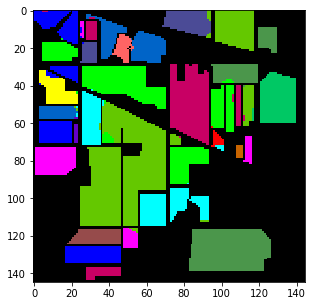

In [34]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))